#Tiêu chí 4: Tỉ lệ học sinh hoàn thành khoá học trên tổng số học sinh đăng ký khoá học
###dựa trên tỉ lệ score trung bình học sinh đặt được trên từng course_id

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 481, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 481 (delta 143), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (481/481), 133.58 KiB | 16.70 MiB/s, done.
Resolving deltas: 100% (245/245), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 640.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.8/137.8 MB 7

In [ ]:
import pandas as pd
import dask.dataframe as dd
import re
import numpy as np
from google.colab import drive
#import cudf

In [ ]:
user_problem_score_df = cudf.read_csv('/content/drive/MyDrive/CS313/user_problem_score_df.csv')
user_problem_score_df

,problem_id,score,count,problem_score
0,47064,1.0,1,1.0
1,47065,1.0,1,1.0
2,47066,0.0,1,0.0
3,47142,0.0,1,0.0
4,57757,0.0,2,0.0
...,...,...,...,...
130545,8591678,0.0,1,0.0
130546,8591679,0.0,1,0.0
130547,8591680,0.0,1,0.0
130548,8591681,0.0,1,0.0


In [ ]:
x = user_problem_score_df[user_problem_score_df['problem_id'] == '47064']
print(x)

Empty DataFrame
Columns: [problem_id, score, count, problem_score]
Index: []


In [ ]:
user_problem_score_df[user_problem_score_df['score'] == -1]

,problem_id,score,count,problem_score
4073,193207,-1.0,1,-1.000000
4074,193208,-1.0,1,-1.000000
4075,193209,-1.0,1,-1.000000
4076,193210,-1.0,1,-1.000000
4077,193211,-1.0,1,-1.000000
...,...,...,...,...
88960,5705373,-1.0,14,-0.071429
88961,5705374,-1.0,14,-0.071429
89313,5705726,-1.0,4,-0.250000
99751,6045838,-1.0,1,-1.000000


In [ ]:
problem_df = cudf.read_csv('/content/drive/MyDrive/CS313/problem_df.csv')
problem_df

,problem_id,exercise_id,score,type
0,1730,856,1.0,1
1,1731,856,1.0,1
2,1732,856,1.0,1
3,1733,856,1.0,1
4,1734,856,1.0,1
...,...,...,...,...
272785,8428791,8632531,2.0,2
272786,8428794,8632536,1.0,1
272787,8428795,8632536,2.0,2
272788,8428800,8632542,1.0,1


In [ ]:
count_zeros = (problem_df['score'] == 0).sum()
print(count_zeros)

447


In [ ]:
problem_df[problem_df['problem_id'] == 47064]

,problem_id,exercise_id,score,type
3746,47064,32356,1.0,1


##Hàm tính problem_score

In [ ]:
# Hàm tính tỷ lệ
def calculate_average_ratio(problem_id):
    # Truy xuất score từ problem_df
    problem_score = problem_df[problem_df['problem_id'] == problem_id]['score'].values
    # Truy xuất user_score từ user_problem_score_df
    user_score = user_problem_score_df[user_problem_score_df['problem_id'] == problem_id]['problem_score'].values

    # Kiểm tra xem có tồn tại score và user_score hay không
    if len(problem_score) > 0 and len(user_score) > 0:
        score_chuan = problem_score[0]
        user_score = user_score[0]
        if user_score > 0 and score_chuan > 0:
            ratio = user_score / score_chuan
        else:
            ratio = 0
    else:
        ratio = 0

    return cudf.DataFrame({'problem_id': [problem_id], 'score': [ratio]})

In [ ]:
x = calculate_average_ratio(47064)
x

,problem_id,score
0,47064,1.0


In [ ]:
problem_ids = problem_df['problem_id'].to_arrow().to_pylist()
results = [calculate_average_ratio(id) for id in problem_ids]
result_df = cudf.concat(results)

In [ ]:
problem_ids = problem_df['problem_id'].to_arrow().to_pylist()
len(problem_ids)

272790

In [ ]:
count_zeros = (result_df['score'] == 0).sum()
print(count_zeros)

190905


In [ ]:
file_path = '/content/drive/MyDrive/CS313/problem_score.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/problem_score.csv


##Exercise_score

In [ ]:
exercise_problem_df = cudf.read_csv('/content/drive/MyDrive/CS313/exercise_problemlist.csv')
exercise_problem_df

,exercise_id,problem_ids
0,856,"[1730, 1731, 1732, 1733, 1734, 1735, 1736, 173..."
1,866,"[1739, 1740, 1741]"
2,876,"[1742, 1743, 1744, 1745, 1746, 1747, 1748, 1749]"
3,882,"[1750, 1751, 1752, 1753, 1754, 1755, 1756, 175..."
4,890,"[1759, 1760, 1761, 1762, 1763, 1764, 1765, 176..."
...,...,...
66699,8825274,"[8573187, 8573188]"
66700,8825277,"[8573189, 8573190]"
66701,8825280,"[8573191, 8573192]"
66702,8825283,"[8573193, 8573194]"


In [ ]:
exercise_problem_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 66704 entries, 0 to 66703
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   exercise_id  66704 non-null  int64
 1   problem_ids  66704 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.5+ MB


In [ ]:
problem_score_df = cudf.read_csv('/content/drive/MyDrive/CS313/problem_score.csv')
problem_score_df

,problem_id,score
0,1730,0.0
1,1731,0.0
2,1732,0.0
3,1733,0.0
4,1734,0.0
...,...,...
272785,8428791,0.0
272786,8428794,0.0
272787,8428795,0.0
272788,8428800,0.0


In [ ]:
# Function to calculate the average score for each exercise_id
def calculate_average_score(problem_list):
    # Split the problem_list into individual IDs
    problem_ids_str = problem_list.split(',')
    problem_ids = []

    # Convert to integers, ignoring non-integer values
    for pid in problem_ids_str:
        try:
            problem_ids.append(int(pid))
        except ValueError:
            continue

    # Retrieve scores from problem_score_df
    scores = []
    for problem_id in problem_ids:
        score = problem_score_df[problem_score_df['problem_id'] == problem_id]['score']
        if len(score) > 0:
            scores.append(score.iloc[0])
        else:
            scores.append(0)

    # Calculate the average score
    average_score = np.mean(scores) if scores else 0
    return float(average_score)

In [ ]:
def ex_score(ex_id):
    # Find the corresponding index for ex_id in exercise_problem_df
    index = exercise_problem_df[exercise_problem_df['exercise_id'] == ex_id].index[0]

    # Get the value of problem_ids at the corresponding index
    problem_ids = exercise_problem_df['problem_ids'].iloc[index]
    score = calculate_average_score(problem_ids)
    return cudf.DataFrame({'exercise_id': [ex_id], 'score': [score]})

In [ ]:
x = ex_score(8825283)
x

,exercise_id,score
0,8825283,0.0


In [ ]:
ex_ids = exercise_problem_df['exercise_id'].to_arrow().to_pylist()
results = [ex_score(id) for id in ex_ids]
result_df = cudf.concat(results)

In [ ]:
count_zeros = (result_df['score'] == 0).sum()
print(count_zeros)

57481


In [ ]:
result_df

,exercise_id,score
0,856,0.0
0,866,0.0
0,876,0.0
0,882,0.0
0,890,0.0
...,...,...
0,8825274,0.0
0,8825277,0.0
0,8825280,0.0
0,8825283,0.0


In [ ]:
file_path = '/content/drive/MyDrive/CS313/exercise_score.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/exercise_score.csv


##Course_score

In [ ]:
course_exercise_df = pd.read_csv('/content/drive/MyDrive/CS313/course-exercise.txt',header=None)
course_exercise_df

,0
0,584313\t856
1,584313\t866
2,584313\t876
3,584313\t882
4,584313\t890
...,...
67320,2329163\t8823965
67321,2329163\t8638639
67322,2329163\t8638640
67323,2329163\t8638641


In [ ]:
course_exercise_df[0]

0             584313\t856
1             584313\t866
2             584313\t876
3             584313\t882
4             584313\t890
               ...       
67320    2329163\t8823965
67321    2329163\t8638639
67322    2329163\t8638640
67323    2329163\t8638641
67324    2329163\t8638642
Name: 0, Length: 67325, dtype: object

In [ ]:
# Tách cột 'combined' thành hai cột 'exercise_id' và 'problem_id'
course_exercise_df[['course_id', 'exercise_id']] = course_exercise_df[0].str.split('\\t', expand=True)

# Xóa cột 'combined' vì không còn cần thiết nữa
course_exercise_df.drop(columns=[0], inplace=True)

# Chuyển đổi các cột thành kiểu dữ liệu phù hợp (nếu cần thiết)
course_exercise_df['course_id'] = course_exercise_df['course_id'].astype(int)
course_exercise_df['exercise_id'] = course_exercise_df['exercise_id'].astype(int)

# Nhóm các problem_id theo exercise_id
grouped = course_exercise_df.groupby('course_id')['exercise_id'].apply(list).reset_index()

# Đổi tên cột kết quả cho rõ ràng hơn
grouped.columns = ['course_id', 'exercise_ids']

# Hiển thị kết quả
print(grouped)

      course_id                                       exercise_ids
0        584313  [856, 866, 876, 882, 890, 895, 900, 910, 916, ...
1        584329  [1368, 1369, 1370, 1371, 1372, 1394, 1395, 139...
2        584381         [1812, 1821, 1834, 1844, 1924, 1925, 1926]
3        597208  [2972, 2973, 2974, 2975, 2976, 2977, 2978, 299...
4        597225  [4612, 4613, 4614, 4615, 4643, 4644, 4645, 464...
...         ...                                                ...
3199    2342518  [8804651, 8804655, 8804659, 8804663, 8804667, ...
3200    2342532  [8805090, 8805092, 8805094, 8805096, 8805098, ...
3201    2343056  [8810981, 8810985, 8810987, 8810992, 8810990, ...
3202    2343067      [8811152, 8811154, 8811156, 8811158, 8811160]
3203    2344479  [8825225, 8825228, 8825231, 8825234, 8825237, ...

[3204 rows x 2 columns]


In [ ]:
result_df = pd.DataFrame(grouped)
file_path = '/content/drive/MyDrive/CS313/course_exlist.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/course_exlist.csv


In [ ]:
course_exerciselist_df = cudf.read_csv('/content/drive/MyDrive/CS313/course_exlist.csv')
course_exerciselist_df

,course_id,exercise_ids
0,584313,"[856, 866, 876, 882, 890, 895, 900, 910, 916, ..."
1,584329,"[1368, 1369, 1370, 1371, 1372, 1394, 1395, 139..."
2,584381,"[1812, 1821, 1834, 1844, 1924, 1925, 1926]"
3,597208,"[2972, 2973, 2974, 2975, 2976, 2977, 2978, 299..."
4,597225,"[4612, 4613, 4614, 4615, 4643, 4644, 4645, 464..."
...,...,...
3199,2342518,"[8804651, 8804655, 8804659, 8804663, 8804667, ..."
3200,2342532,"[8805090, 8805092, 8805094, 8805096, 8805098, ..."
3201,2343056,"[8810981, 8810985, 8810987, 8810992, 8810990, ..."
3202,2343067,"[8811152, 8811154, 8811156, 8811158, 8811160]"


In [ ]:
ex_score_df = cudf.read_csv('/content/drive/MyDrive/CS313/exercise_score.csv')
ex_score_df

,exercise_id,score
0,856,0.0
1,866,0.0
2,876,0.0
3,882,0.0
4,890,0.0
...,...,...
66699,8825274,0.0
66700,8825277,0.0
66701,8825280,0.0
66702,8825283,0.0


In [ ]:
# Function to calculate the average score for each exercise_id
def calculate_average_score(ex_list):
    # Split the problem_list into individual IDs
    ex_ids_str = ex_list.split(',')
    ex_ids = []

    # Convert to integers, ignoring non-integer values
    for eid in ex_ids_str:
        try:
            ex_ids.append(int(eid))
        except ValueError:
            continue

    # Retrieve scores from problem_score_df
    scores = []
    for ex_id in ex_ids:
        score = ex_score_df[ex_score_df['exercise_id'] == ex_id]['score']
        if len(score) > 0:
            scores.append(score.iloc[0])
        else:
            scores.append(0)

    # Calculate the average score
    average_score = np.mean(scores) if scores else 0
    return float(average_score)

In [ ]:
def course_score(course_id):
    # Find the corresponding index for ex_id in exercise_problem_df
    index = course_exerciselist_df[course_exerciselist_df['course_id'] == course_id].index[0]

    # Get the value of problem_ids at the corresponding index
    ex_ids = course_exerciselist_df['exercise_ids'].iloc[index]
    score = calculate_average_score(ex_ids)
    return cudf.DataFrame({'course_id': [course_id], 'score': [score]})

In [ ]:
x = course_score(597225)
x

,course_id,score
0,597225,0.0


In [ ]:
course_ids = course_exerciselist_df['course_id'].to_arrow().to_pylist()
results = [course_score(id) for id in course_ids]
result_df = cudf.concat(results)

In [ ]:
count_zeros = (result_df['score'] == 0).sum()
print(count_zeros)

2324


In [ ]:
file_path = '/content/drive/MyDrive/CS313/course_score.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/course_score.csv


##Full Course_score

In [ ]:
course_df = dd.read_json('/content/drive/MyDrive/CS313/course.json')
course_df

,id,name,field,prerequisites,about,resource
npartitions=1,,,,,,
,string,string,string,string,string,string
,...,...,...,...,...,...


In [ ]:
course_df = course_df.iloc[:, [0]]

# Compute and print the resulting DataFrame to verify
print(course_df.compute())

             id
0      C_584313
1      C_584329
2      C_584381
3      C_597208
4      C_597225
...         ...
3776  C_2338076
3777  C_2341259
3778  C_2337996
3779  C_1945689
3780  C_2329163

[3781 rows x 1 columns]


In [ ]:
file_path = '/content/drive/MyDrive/CS313/course_id.csv'
course_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/course_id.csv


In [ ]:
course_id_df = cudf.read_csv('/content/drive/MyDrive/CS313/course_id.csv/course_id.txt')
course_id_df

,id
0,C_584313
1,C_584329
2,C_584381
3,C_597208
4,C_597225
...,...
3776,C_2338076
3777,C_2341259
3778,C_2337996
3779,C_1945689


In [ ]:
course_score_df = cudf.read_csv('/content/drive/MyDrive/CS313/course_score.csv')
course_score_df

,course_id,score
0,584313,0.0
1,584329,0.0
2,584381,0.0
3,597208,0.0
4,597225,0.0
...,...,...
3199,2342518,0.0
3200,2342532,0.0
3201,2343056,0.0
3202,2343067,0.0


In [ ]:
# Initialize an empty list to store the results
results = []

# Iterate through each course_id in course_id_df
for course_id in course_id_df['id'].to_arrow().to_pylist():
    stripped_course_id = int(course_id.split('_')[1])

    # Try to get the score for the current stripped_course_id
    score = course_score_df[course_score_df['course_id'] == stripped_course_id]['score']

    # If the score exists, get the value; otherwise, assign 0
    if len(score) > 0:
        results.append((course_id, score.iloc[0]))
    else:
        results.append((course_id, 0))

# Create a new DataFrame with the results
result_df = cudf.DataFrame(results, columns=['course_id', 'score'])

# Display the result DataFrame
print(result_df)

      course_id     score
0      C_584313  0.000000
1      C_584329  0.000000
2      C_584381  0.000000
3      C_597208  0.000000
4      C_597225  0.000000
...         ...       ...
3776  C_2338076  0.000000
3777  C_2341259  0.000000
3778  C_2337996  0.000000
3779  C_1945689  0.208333
3780  C_2329163  0.000000

[3781 rows x 2 columns]


In [ ]:
count_zeros = (result_df['score'] == 0).sum()
print(count_zeros)

2901


In [ ]:
file_path = '/content/drive/MyDrive/CS313/full_course_score.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/full_course_score.csv


In [ ]:
full_course_score_df = cudf.read_csv('/content/drive/MyDrive/CS313/full_course_score.csv')
full_course_score_df

,course_id,score
0,C_584313,0.000000
1,C_584329,0.000000
2,C_584381,0.000000
3,C_597208,0.000000
4,C_597225,0.000000
...,...,...
3776,C_2338076,0.000000
3777,C_2341259,0.000000
3778,C_2337996,0.000000
3779,C_1945689,0.208333


##Xếp hạng 1 - 5

In [ ]:
full_course_score_df = full_course_score_df.to_pandas()

In [ ]:
# Calculate the quantiles for the scores
quantiles = full_course_score_df['score'].quantile([0.2, 0.8, 0.85, 0.95])

# Function to assign rank based on score
def assign_rank(score, quantiles):
    if score <= quantiles.loc[0.2]:
        return 1
    elif score <= quantiles.loc[0.8]:
        return 2
    elif score <= quantiles.loc[0.85]:
        return 3
    elif score <= quantiles.loc[0.95]:
        return 4
    else:
        return 5

# Apply the ranking function to the score column
full_course_score_df['rank'] = full_course_score_df['score'].apply(lambda x: assign_rank(x, quantiles))

# Display the result DataFrame
print(full_course_score_df)

      course_id     score  rank
0      C_584313  0.000000     1
1      C_584329  0.000000     1
2      C_584381  0.000000     1
3      C_597208  0.000000     1
4      C_597225  0.000000     1
...         ...       ...   ...
3776  C_2338076  0.000000     1
3777  C_2341259  0.000000     1
3778  C_2337996  0.000000     1
3779  C_1945689  0.208333     3
3780  C_2329163  0.000000     1

[3781 rows x 3 columns]


In [ ]:
file_path = '/content/drive/MyDrive/CS313/course_score_rank.csv'
full_course_score_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')

DataFrame đã được lưu vào /content/drive/MyDrive/CS313/course_score_rank.csv


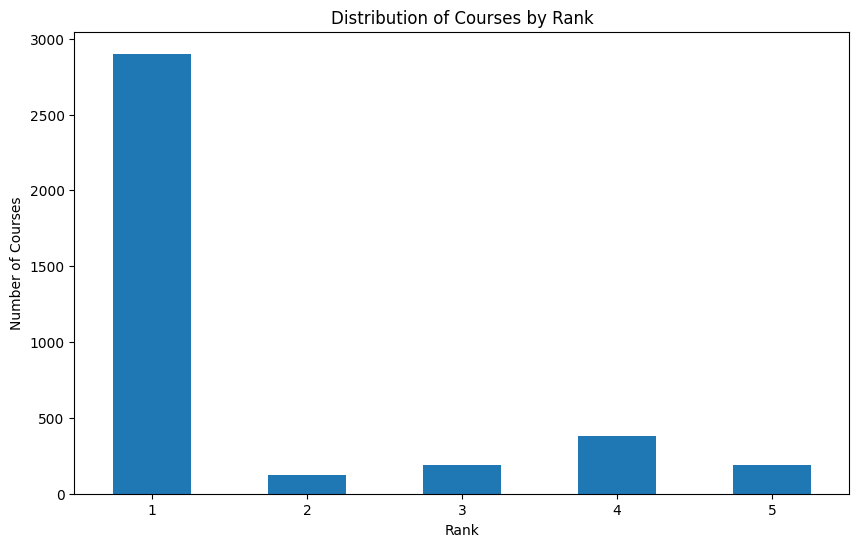

In [ ]:
import matplotlib.pyplot as plt
# Plot the distribution of course_ids for each rank
rank_counts = full_course_score_df['rank'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
rank_counts.plot(kind='bar')
plt.xlabel('Rank')
plt.ylabel('Number of Courses')
plt.title('Distribution of Courses by Rank')
plt.xticks(rotation=0)
plt.show()

##Course

In [ ]:
course_df = dd.read_json('/content/drive/MyDrive/CS313/data/entities/course.json')
course_df.head()

,id,name,field,prerequisites,about,resource
0,C_584313,《资治通鉴》导读,"['历史学', '中国语言文学']",,通过老师导读，同学们可深入这一经典文本内部，得以纵览千年历史，提升国学素养，体味人生智慧。,"[{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso..."
1,C_584329,微积分——极限理论与一元函数,"['应用经济学', '数学', '物理学', '理论经济学']",,本课程是理工科的一门数学基础课，系统、全面地介绍了一元函数微积分学。课程既保持了数学的严谨和...,"[{'titles': ['序言', '序言', '序言'], 'resource_id':..."
2,C_584381,新闻摄影,"['艺术学', '新闻传播学']",,掌握基本的摄影技能，了解图片新闻的工作方式，训练对生活的观察和热爱，发展对图像的审美和批评能...,"[{'titles': ['第一章 绪论', '第一讲 引言1', '引言1'], 'res..."
3,C_597208,数据挖掘：理论与算法,['计算机科学与技术'],,最有趣的理论+最有用的算法=不得不学的数据科学。,"[{'titles': ['走进数据科学：博大精深，美不胜收', '整装待发', 'Vide..."
4,C_597225,大学计算机,[],,大学计算机课程将以计算思维为导向，以计算机原理、概念为基础，以新技术新方法为牵引，以创新思维...,"[{'titles': ['第1周： 基于计算机的问题求解', '课程介绍', '开篇'],..."


In [ ]:
x = course_df.loc[course_df['id'] == 'C_584313']['resource'].compute()
x

0    [{'titles': ['第一课 导论与三家分晋', '导论', '导论'], 'reso...
Name: resource, dtype: string

In [ ]:
ex_problem_df = pd.read_csv('/content/drive/MyDrive/CS313/data/Input/exercise-problem.txt',header=None)
ex_problem_df

,0
0,856\t1730
1,856\t1731
2,856\t1732
3,856\t1733
4,856\t1734
...,...
461175,8825280\t8573192
461176,8825283\t8573193
461177,8825283\t8573194
461178,8825286\t8573195


In [ ]:
def ex_pro(ex_id): #ex_id => pro_id
  ex_id = ex_id.split('_')[1]
  ex_list = []
  result_list = []

    # Duyệt qua từng phần tử trong cột văn bản của DataFrame
  for text in ex_problem_df[0]:
    text = text.split('\t')
    if text[0] == ex_id:
      result_list.append(text[1])
  return result_list

In [ ]:
def process_course_id(course_id):
  resource = course_df.loc[course_df['id'] == course_id]['resource'].compute()
  if len(resource) == 0:
    return cudf.DataFrame({'course_id': [course_id], 'score': [None]})
  pattern = r'Ex_\w*'
  ex_id = re.findall(pattern, resource.iloc[0]) #Ex_12344
  problem_list = []
  for i in ex_id:
    problem_list += ex_pro(i)
  score = calculate_average_ratio(problem_list)
  return cudf.DataFrame({'course_id': [course_id], 'score': [score]})

In [ ]:
x = process_course_id('C_584313')
x

,course_id,score
0,C_584313,0.0


In [ ]:
# Lấy giá trị course_id từ course_df
course_ids = course_df['id'].compute()

# Áp dụng hàm process_course_id cho từng course_id và tạo một danh sách các DataFrame kết quả
results = [process_course_id(course_id) for course_id in course_ids]

# Kết hợp các DataFrame trong danh sách lại thành một DataFrame duy nhất
result_df = cudf.concat(results)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/di

KeyboardInterrupt: 

In [ ]:
result_df = cudf.concat(results)

NameError: name 'results' is not defined

In [ ]:
file_path = '/content/drive/MyDrive/CS313/course_score.csv'
result_df.to_csv(file_path, index=False)

print(f'DataFrame đã được lưu vào {file_path}')